# data extraction & conversion from .mat to a data frame

In [1]:
from pymatreader import read_mat

data = read_mat('P1.mat')

In [2]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'dof', 'sigma2', 'y', 'Xtrain', 'Xtest'])

In [3]:
import pandas as pd
import numpy as np 

df = pd.DataFrame([data['Xtrain'].T,data['y'].T])

In [4]:
df = df.transpose()

In [5]:
df

,0,1
0,0.383442,2.058608
1,0.423655,1.876205
2,0.437587,1.943219
3,0.544883,2.515363
4,0.548814,1.668663
5,0.602763,1.792656
6,0.645894,1.812007
7,0.715189,2.762999
8,0.891773,3.061703
9,0.963663,3.297338


In [6]:
df.rename(columns = {0:'x', 1:'y'}, inplace = True)

In [7]:
df

,x,y
0,0.383442,2.058608
1,0.423655,1.876205
2,0.437587,1.943219
3,0.544883,2.515363
4,0.548814,1.668663
5,0.602763,1.792656
6,0.645894,1.812007
7,0.715189,2.762999
8,0.891773,3.061703
9,0.963663,3.297338


In [8]:
np.sum(df['x'].apply(lambda x : x**2).values)

5.201991023528755

In [9]:
np.sum(df['x'].values)

7.657662833145425

now we have converted the data in the form that can be handled by python packages like pandas and numpy ; so let us fit a linear model as specified in part (a) of the problem number three to this data. 

# problem three - Part A

$$ \hat{y} =  w_0 + w_1 x $$

we have to then fit this model in the conventional manner to the training data and then compute the mean-squared-error ; find the parameters that minimise this loss function and then generate the predictions for the test set given in the problem 

$$E_D (w) = \frac{1}{2} \sum_{n = 1}^{N} (y_i - \hat{y_i})^{2}$$

$$ E_D (w) = \frac{1}{2} \sum_{n = 1}^{N} (y_i - w_0 - w_1 x_i)^{2}$$

we then have to compute the derivative of this loss with repsect to the weights $\, w_0 \,$ and  $\,w_1\,$ which are as follows : 

$$\frac{\partial E}{\partial w_0} = \sum_{n=1}^{N} (y_i - w_0 - w_1 x_i) = 0 $$
$$\frac{\partial E}{\partial w_1} = \sum_{n=1}^{N} (y_i - w_0 - w_1 x_i)\cdot x_i \, = \sum_{n=1}^{N} (y_i \cdot x_i - w_0 \cdot x_i - w_1 x_i^{2}) = 0 $$

this will give us a system of linear equations in $w_0$ and $w_1$ which has to be solved simultaneously to find out the solution for $\vec{w}$ = $( w_0, w_1) $

In [10]:
import numpy as np 

def compute_weights(dataset):
    
    a = len(dataset) # total number of data points in the training sample
    b = np.sum(dataset['x'].values)
    c = np.sum(dataset['y'].values)
    d = np.sum(dataset['x'].apply(lambda x : x**2).values)
    e = 0 
    
    for i in range(dataset.values.shape[0]):
        e+= dataset.values[i][0]* dataset.values[i][1]
    
    w = np.linalg.inv(np.array([[a, b],[b, d]])) @ np.array([c,e]) 
    
    return w

In [11]:
w = compute_weights(df)

In [12]:
y_hat = [] 

for i in range(df.values.shape[0]):
    y_hat.append(w[0]+w[1]*df['x'].values[i])

y_hat

[-0.22414426814783805,
 -0.06312652031554888,
 -0.007339835886564394,
 0.4222833010390308,
 0.43802067477229345,
 0.6540410242108954,
 0.8267405415013744,
 1.1042052367559614,
 1.8112626753402687,
 2.099116017680022,
 -1.359070700936427,
 0.24256682554915665,
 1.8442043520347404]

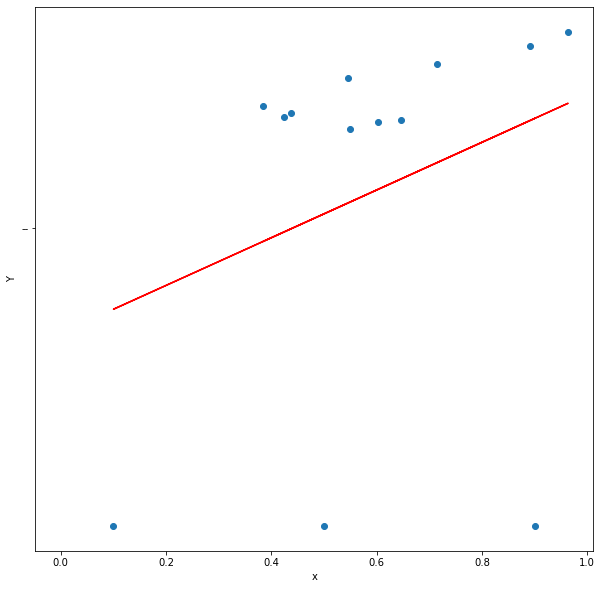

In [13]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,10))
plt.xlabel('x')
plt.ylabel('Y')
plt.plot(df['x'].values, y_hat, 'r', '--')
plt.scatter(df['x'].values, df['y'].values)

In [14]:
test = data['Xtest']

In [15]:
test

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [16]:
preds = w[0] + w[1]*test

In [17]:
preds # predictions using the normal least squares minimisation method 

array([-1.75948008, -1.3590707 , -0.95866132, -0.55825194, -0.15784256,
        0.24256683,  0.64297621,  1.04338559,  1.44379497,  1.84420435,
        2.24461373])

# problem three - Part B 

in this problem we have to fit in a students' T, Laplace distribution instead of a normal distribution to the likelihood with the following paramters : 

1. for the student's T distribution we have, $\,\nu = 0.6296 $
2. for the laplace distribution we have , $\,2b^2 = 0.0688 $


In [18]:
import pymc3 as p

In [19]:
x = df['x'].values
y = df['y'].values
with p.Model() as model:
    w0 = p.Uniform('w0', -100, 100)
    w1 = p.Uniform('w1', -100, 100)
    
    y_hat = w0 + w1 * x
    
    preds = p.StudentT('preds', nu=0.6296, mu = y_hat, observed = y)

In [20]:
with model:
    step = p.NUTS()
    trace_ = p.sample(3000, step)
    
burn = 1000
thin = 2
trace = trace_[burn::thin]

<ipython-input-20-e85d00e3787c>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_ = p.sample(3000, step)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w1, w0]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [21]:
w0 = trace['w0'].mean()
w1 = trace['w1'].mean()

In [22]:
w0

0.6289856426585236

In [23]:
w1

2.5535629879327857

In [24]:
predictions = w0 + w1*test

In [25]:
predictions

array([0.62898564, 0.88434194, 1.13969824, 1.39505454, 1.65041084,
       1.90576714, 2.16112344, 2.41647973, 2.67183603, 2.92719233,
       3.18254863])

# graph for the regression line when we use a Student's T likelihood : 

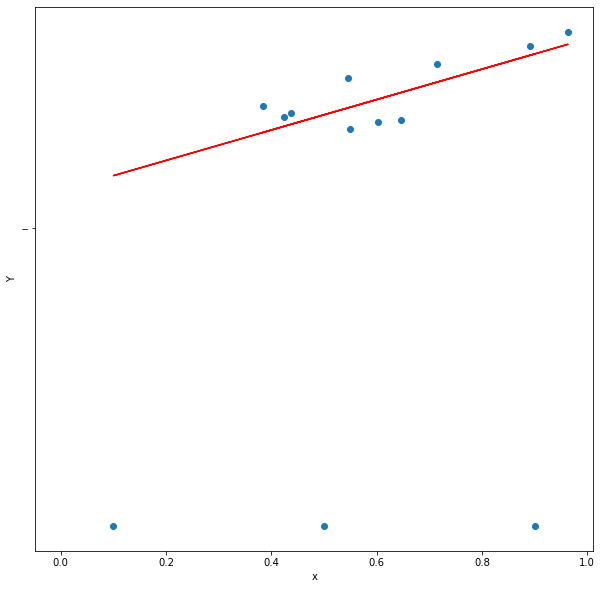

In [26]:
plt.figure(figsize=(10,10))
plt.xlabel('x')
plt.ylabel('Y')
plt.plot(df['x'].values, w0 + w1*x, 'r', '--')
plt.scatter(df['x'].values, df['y'].values)

In [27]:
x = df['x'].values
y = df['y'].values
with p.Model() as model:
    w0 = p.Uniform('w0', -100, 100)
    w1 = p.Uniform('w1', -100, 100)
    
    y_hat = w0 + w1 * x
    
    preds = p.Laplace('preds', mu = y_hat, b = 0.131148770486, observed = y)

In [28]:
with model:
    step = p.NUTS()
    trace_ = p.sample(3000, step)
    
burn = 1000
thin = 2
trace = trace_[burn::thin]

<ipython-input-28-e85d00e3787c>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_ = p.sample(3000, step)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w1, w0]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 21 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [29]:
w0 = trace['w0'].mean()
w1 = trace['w1'].mean()

In [30]:
w0

-0.0426549027522886

In [31]:
w1

3.427272091587168

In [32]:
predictions = w0 + w1*test

In [33]:
predictions

array([-0.0426549 ,  0.30007231,  0.64279952,  0.98552672,  1.32825393,
        1.67098114,  2.01370835,  2.35643556,  2.69916277,  3.04188998,
        3.38461719])

# graph for the regression line when we use a Laplace likelihood : 

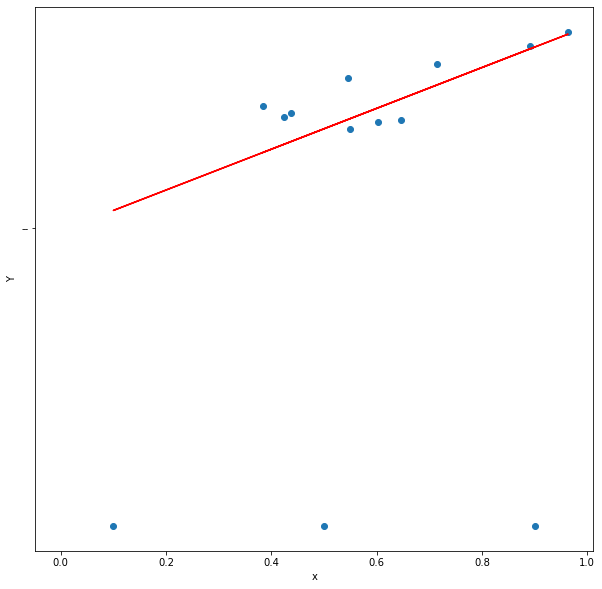

In [34]:
plt.figure(figsize=(10,10))
plt.xlabel('x')
plt.ylabel('Y')
plt.plot(df['x'].values, w0 + w1*x, 'r', '--')
plt.scatter(df['x'].values, df['y'].values)

# problem three - Part C

this problem we have to use the Huber Loss function that is defined as a mixture of the $\,L_2\,$ and $\,L_1\,$ losses. 

In [35]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://miro.medium.com/max/1050/1*0eoiZGyddDqltzzjoyfRzA.png")

as we can see in the figure we have to use a parameter $\delta$ for mixing the loss functions ; we will take two cases : 

1. $\delta = 1.0$
2. $\delta = 5.0$

#  Case : $ \delta = 1.0$


In [36]:
def learning_rate_generator():
    return np.random.randint(1,3)/10 + np.random.randint(0, 10)/100

In [37]:
def update_weights_Huber(X, Y, learning_rate, W0, W1, delta):
    W1_deriv = 0
    W0_deriv = 0
    N = len(X)
    for i in range(N):
        # derivative of quadratic for small values and of linear for large values
        
        if abs(Y[i] - W1*X[i] - W0) <= delta:
            W1_deriv += -X[i] * (Y[i] - (W1*X[i] + W0))
            W0_deriv += - (Y[i] - (W1*X[i] + W0))
        
        else:
            W1_deriv += delta * X[i] * ((W1*X[i] + W0) - Y[i]) / abs((W1*X[i] + W0) - Y[i])
            W0_deriv += delta * ((W1*X[i] + W0) - Y[i]) / abs((W1*X[i] + W0) - Y[i])
    
    # We subtract because the derivatives point in direction of steepest ascent
        
        W1 -= (W1_deriv / float(N)) * learning_rate
        W0 -= (W0_deriv / float(N)) * learning_rate

    return W1, W0

In [38]:
w0, w1 = np.random.rand(1)[0], np.random.rand(1)[0]
w0, w1 = update_weights_Huber(x,y,learning_rate_generator(), w0, w1, 1.0)

In [39]:
w0

1.325319798260938

In [40]:
w1

1.0078185673110334

In [41]:
predictions = w0 + w1*test

In [42]:
predictions

array([1.3253198 , 1.42610165, 1.52688351, 1.62766537, 1.72844723,
       1.82922908, 1.93001094, 2.0307928 , 2.13157465, 2.23235651,
       2.33313837])

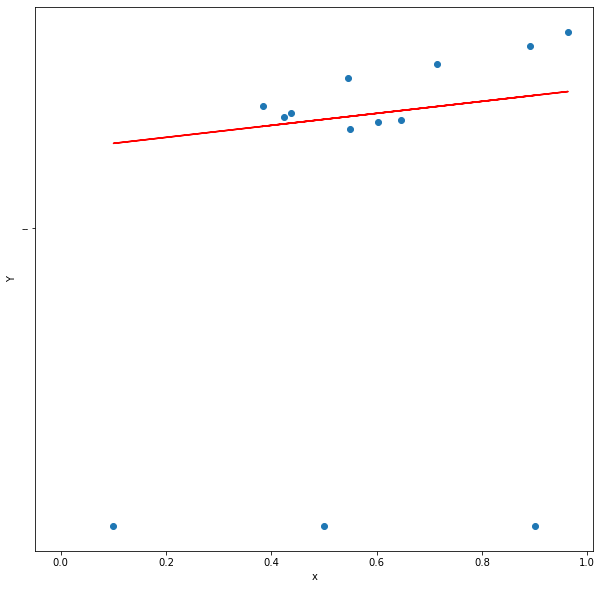

In [43]:
plt.figure(figsize=(10,10))
plt.xlabel('x')
plt.ylabel('Y')
plt.plot(df['x'].values, w0 + w1*x, 'r', '--')
plt.scatter(df['x'].values, df['y'].values)

#  Case : $ \delta = 5.0$

In [44]:
w0, w1 = np.random.random(1)[0], np.random.random(1)[0]
w0, w1 = update_weights_Huber(x,y,learning_rate_generator(), w0, w1, 5.0)

In [45]:
w0

0.5709131298430092

In [46]:
w1

1.169001063922871

In [47]:
predictions = w0 + w1*test

In [48]:
predictions

array([0.57091313, 0.68781324, 0.80471334, 0.92161345, 1.03851356,
       1.15541366, 1.27231377, 1.38921387, 1.50611398, 1.62301409,
       1.73991419])

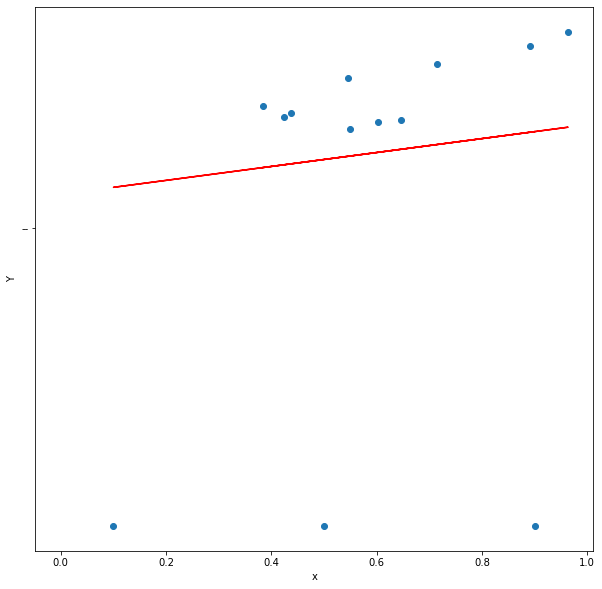

In [49]:
plt.figure(figsize=(10,10))
plt.xlabel('x')
plt.ylabel('Y')
plt.plot(df['x'].values, w0 + w1*x, 'r', '--')
plt.scatter(df['x'].values, df['y'].values)

# discussion : 

1. when we use the least squares method to find the weights, we get a line that is not as robust to the outliers but still get a pretty valid solution which can be optimised if we try to increased the size of the training data
2. using the Laplace or the Student's T likelihood really punishes the outliers ( the gaussian likelihood has very lean tails hence the probability assigned to the outliers is low but the use of the heavy tailed distrubution can help us get rid of this) 
3. the huber loss function is less sensitive to the outliers than the laplace and the student's t distribution and furthermore if we increase the value of $\delta$ this model becomes less and more robust for the current dataset of 13 samples 